In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces 
import warnings
warnings.filterwarnings("ignore") 

# Environment Setup

In [2]:
class UAV_env(gym.Env):
    
    def __init__(self, action='discrete', terminate=True, render_mode=None): # action = 'box' for continuous action space, 'discrete' for discrete action space
        super(UAV_env, self).__init__()

        # UAV parameters
        self.m = 1.56  # Mass (kg)
        self.Jyy = 0.0576  # Moment of inertia (kg-m^2)
        self.CL = lambda a: (3.5*a) + 0.09  # Lift coefficient
        self.CD = lambda a: (0.2*a) + 0.016  # Drag coefficient
        self.CLdelta = 0.27  # Lift coefficient derivative
        self.Cm0 = -0.02  # Pitching moment coefficient at zero angle of attack
        self.Cmalpha = -0.57  # Pitching moment coefficient derivative
        self.Cmq = -1.4  # Pitching moment coefficient derivative
        self.Cmdelta = -0.32  # Pitching moment coefficient derivative

        # State and control constraints
        self.T_min = 0
        self.T_max = 4
        self.delta_min = -0.4363
        self.delta_max = 0.1745
        self.Va_min = 5
        self.Va_max = 15
        self.alpha_min = 0
        self.alpha_max = 0.2618

        # Simulation time
        self.dt = 0.02  # Sampling time (seconds)
        self.t_final = 10  # Final time (seconds)
        self.t = 0  # Initial time

        # Initial state
        self.X0 = np.array([9.96, 0.87, 0, 0.0873, 50])  # [u, w, q, theta, h]
        self.U0 = np.array([1.0545, -0.2179])  # [T, delta]

        # Desired final state
        self.Xd = np.array([9.85, 1.74, 0, 0.1745, 62])

        # Discrete action space list
        self.Ud = [[self.T_min, self.delta_min], [self.T_min, self.delta_max], [self.T_max, self.delta_min], [self.T_max, self.delta_max]]

        # Define action and observation spaces

        if action == 'box':
            self.action_space = spaces.Box(low=np.array([self.T_min, self.delta_min]), high=np.array([self.T_max, self.delta_max]), dtype=np.float64) # Continuous action space
            self.transform = lambda a: a

        elif action == 'discrete':
            self.action_space = spaces.Discrete(4) # Discrete action space
            self.transform = lambda a: self.Ud[a] if self.t > 0 else self.U0
        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float64)

        self.state = None
        self.penalty = -100
        self.terminate = terminate

    def dynamics(self, X, U):
        u, w, q, theta, h = X       # States
        T, delta = U                # Controls

        Va = np.sqrt(u**2 + w**2)   # Airspeed (need to check this to keep within constraints)
        alpha = np.arctan(w / u)    # Angle of attack (need to check this to keep within constraints)

        CL = self.CL(alpha)         # Lift coefficient
        CD = self.CD(alpha)         # Drag coefficient

        udot = (-q*w) + (0.5*Va**2/self.m) * (CL*np.sin(alpha) - CD*np.cos(alpha) + self.CLdelta*np.sin(alpha)*delta) - (9.81*np.sin(theta)) + (T/self.m)
        wdot = (q*u) + (0.5*Va**2/self.m) * (-CL*np.cos(alpha) - CD*np.sin(alpha) - self.CLdelta*np.cos(alpha)*delta) + (9.81*np.cos(theta))
        qdot = (0.5*Va**2/self.Jyy) * (self.Cm0 + self.Cmalpha*alpha + (0.25*self.Cmq*q/Va) + self.Cmdelta*delta)
        thetadot = q
        hdot = (-u*np.sin(theta)) + (w*np.cos(theta))

        return np.array([udot, wdot, qdot, thetadot, hdot]) # Return state derivatives

    def step(self, action):
        action = self.transform(action) # Transform discrete action
        # action = np.clip(action, self.action_space.low, self.action_space.high) # Clip continuous action
        self.state = self.integrate(self.state, action) 
        reward = -np.sum(np.abs(self.state - self.Xd)) # Negative sum of absolute state errors
        done = False
        u, w, _, _, _ = self.state
        Va = np.sqrt(u**2 + w**2)
        alpha = np.arctan(w / u)
        if Va < self.Va_min or Va > self.Va_max or alpha < self.alpha_min or alpha > self.alpha_max:
            reward = self.penalty  # Penalize out of bounds states
            if self.terminate:
                done = True
        if self.t >= 10:
            done = True
        info = {'Va': Va, 'alpha': alpha}
        return self.state, reward, done, False, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.copy(self.X0)
        self.t = 0
        info = {}
        return self.state, info

    def integrate(self, X, U):
        X_dot = self.dynamics(X, U)
        X += self.dt * X_dot
        self.t += self.dt
        return X

    # def render_mode(self, mode):
    #     pass

In [3]:
def plot(env, state, action, info, reward, time, episode):
    
    u, w, q, theta, h = np.array(state).T
    T, delta = np.array(action).T
    Va, alpha = np.array(info).T
    R = np.array(reward)
    t = np.array(time)
    Xd = env.Xd
    X0 = env.X0
    u0, w0, q0, theta0, h0 = X0
    ud, wd, qd, thetad, hd = Xd
    Tmin, Tmax = env.T_min, env.T_max
    deltamin, deltamax = env.delta_min, env.delta_max
    Vmin, Vmax = env.Va_min, env.Va_max
    alphamin, alphamax = env.alpha_min, env.alpha_max

    plt.figure(figsize=(40, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, u)
    plt.plot(t, u0*np.ones_like(t), '--', label='u_0')
    plt.plot(t, ud*np.ones_like(t), '--', label='u_d')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.legend(loc='upper right')
    plt.suptitle('Episode:{} State'.format(episode+1))
    plt.subplot(1, 5, 2)
    plt.plot(t, w)
    plt.plot(t, w0*np.ones_like(t), '--', label='w_0')
    plt.plot(t, wd*np.ones_like(t), '--', label='w_d')
    plt.xlabel('t')
    plt.ylabel('w')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 3)
    plt.plot(t, q)
    plt.plot(t, q0*np.ones_like(t), '--', label='q_0')
    plt.plot(t, qd*np.ones_like(t), '--', label='q_d')
    plt.xlabel('t')
    plt.ylabel('q')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 4)
    plt.plot(t, theta)
    plt.plot(t, theta0*np.ones_like(t), '--', label='theta_0')
    plt.plot(t, thetad*np.ones_like(t), '--', label='theta_d')
    plt.xlabel('t')
    plt.ylabel('theta')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 5)
    plt.plot(t, h)
    plt.plot(t, h0*np.ones_like(t), '--', label='h_0')
    plt.plot(t, hd*np.ones_like(t), '--', label='h_d')
    plt.xlabel('t')
    plt.ylabel('h')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, T)
    plt.plot(t, Tmin*np.ones_like(t), '--', label='T_min')
    plt.plot(t, Tmax*np.ones_like(t), '--', label='T_max')
    plt.xlabel('t')
    plt.ylabel('T')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 2)
    plt.plot(t, delta)
    plt.plot(t, deltamin*np.ones_like(t), '--', label='delta_min')
    plt.plot(t, deltamax*np.ones_like(t), '--', label='delta_max')
    plt.xlabel('t')
    plt.ylabel('delta')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 3)
    plt.plot(t, Va)
    plt.plot(t, Vmin*np.ones_like(t), '--', label='Va_min')
    plt.plot(t, Vmax*np.ones_like(t), '--', label='Va_max')
    plt.xlabel('t')
    plt.ylabel('Va')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 4)
    plt.plot(t, alpha)
    plt.plot(t, alphamin*np.ones_like(t), '--', label='alpha_min')
    plt.plot(t, alphamax*np.ones_like(t), '--', label='alpha_max')
    plt.xlabel('t')
    plt.ylabel('alpha')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 5)
    plt.plot(t, R)
    plt.plot(t, np.zeros_like(t), '--', label='target')
    plt.plot(t, env.penalty*np.ones_like(t), '--', label='penalty')
    plt.xlabel('t')
    plt.ylabel('reward')
    plt.legend(loc='upper right')
    plt.suptitle('Episode:{} Action'.format(episode+1))
    plt.tight_layout()
    plt.show()

# Environment Test

Episode:1 Score:-34519.05477891536


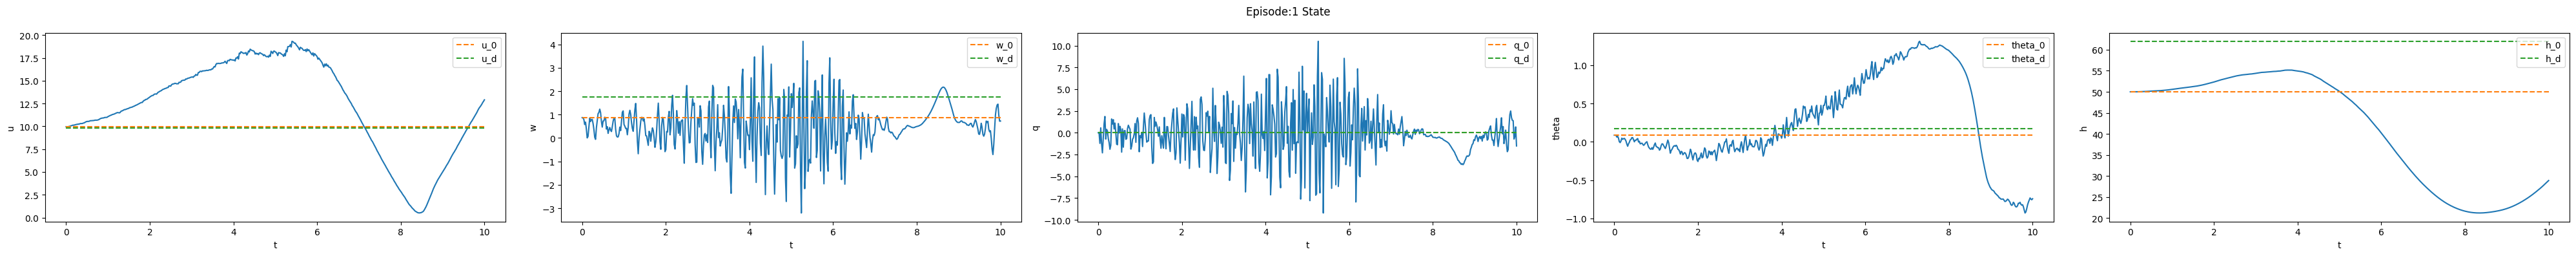

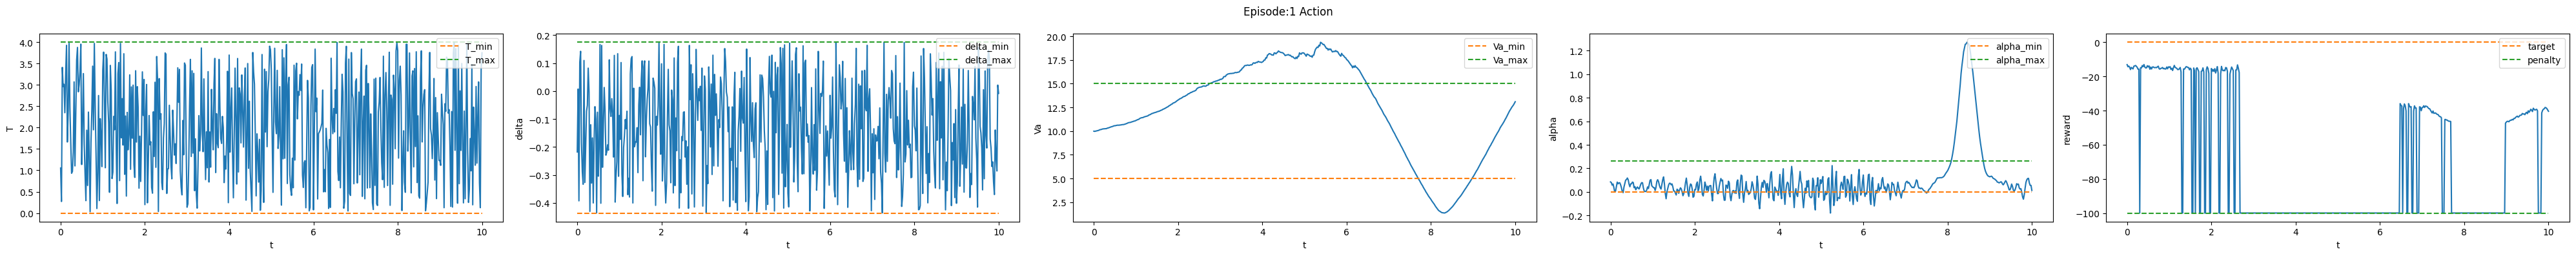

Episode:2 Score:nan


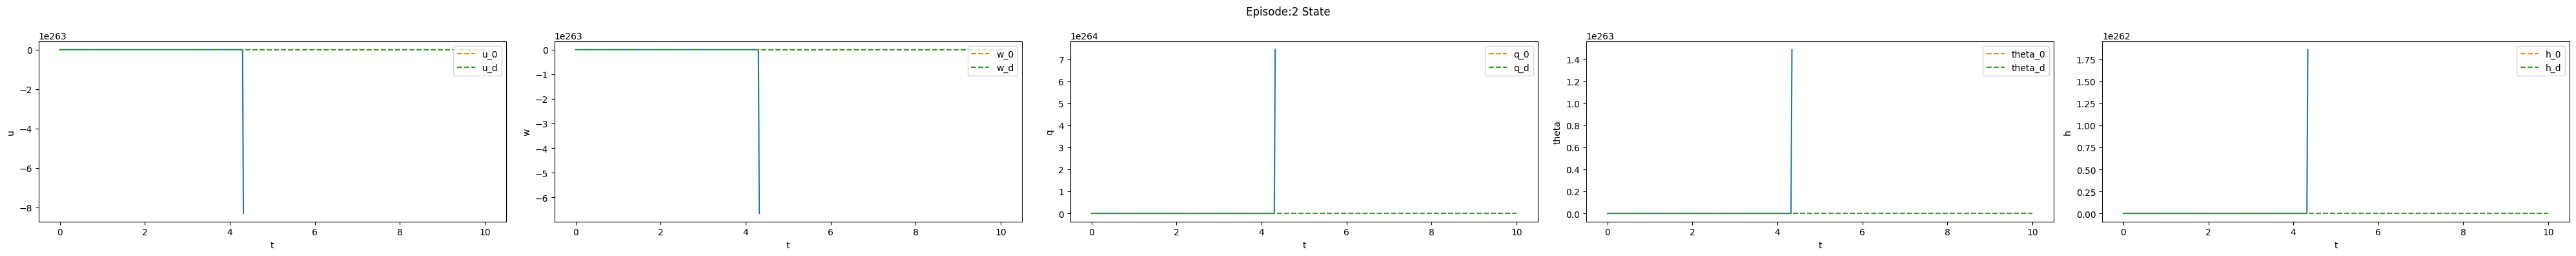

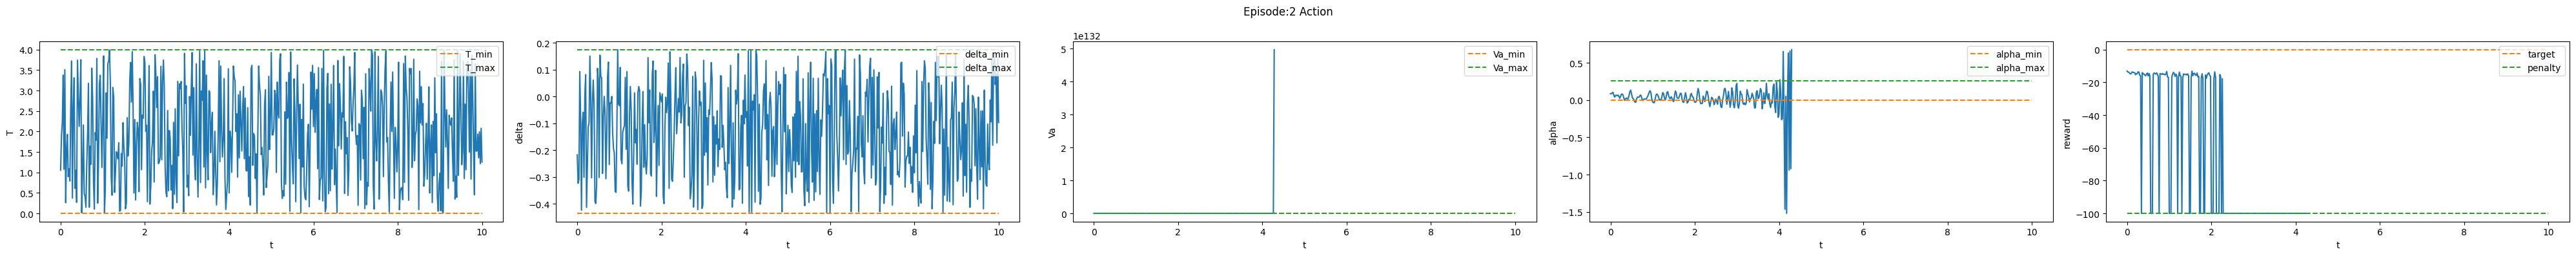

Episode:3 Score:nan


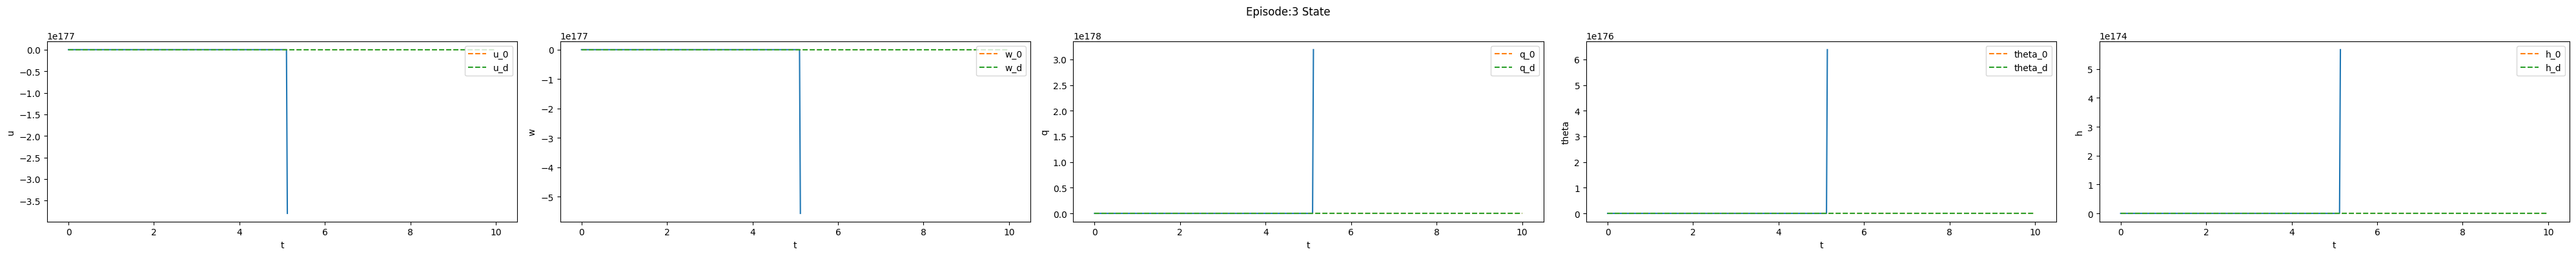

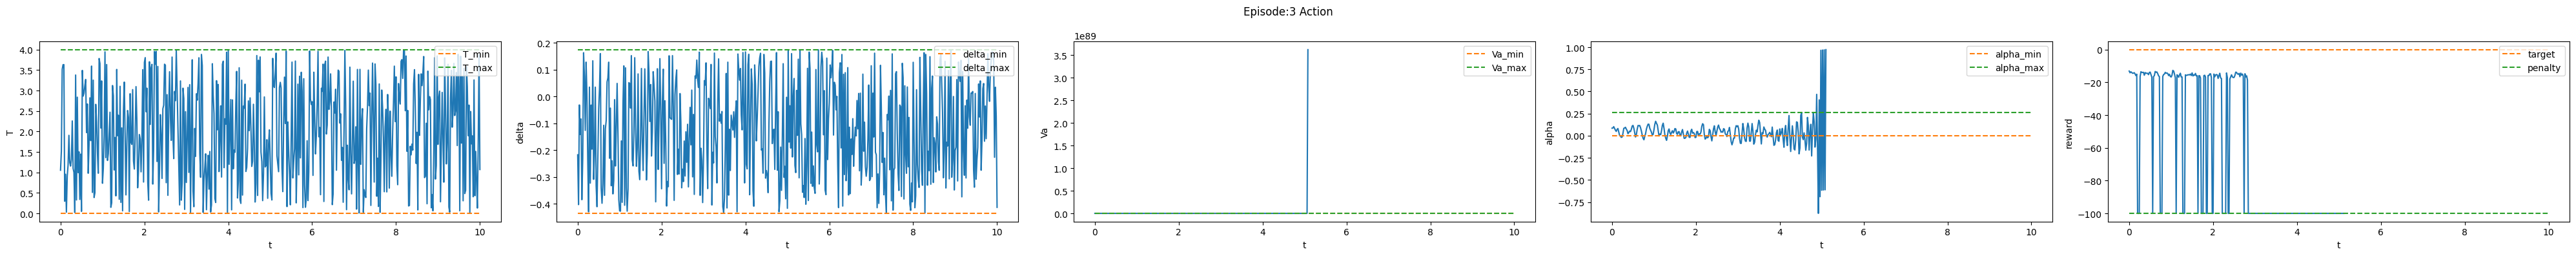

Episode:4 Score:-26686.6127197955


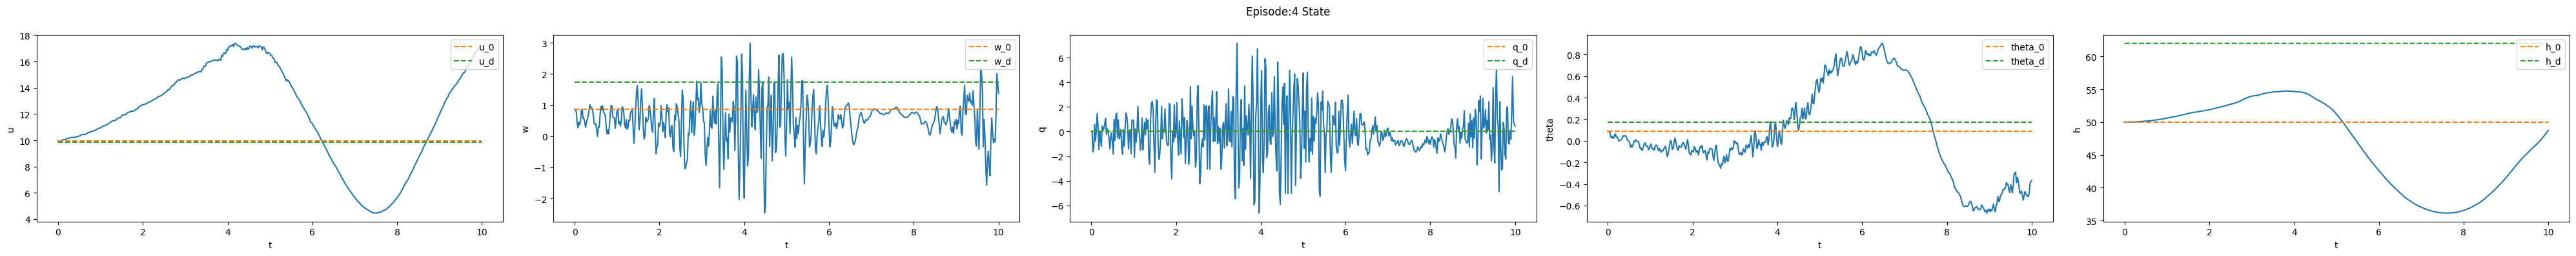

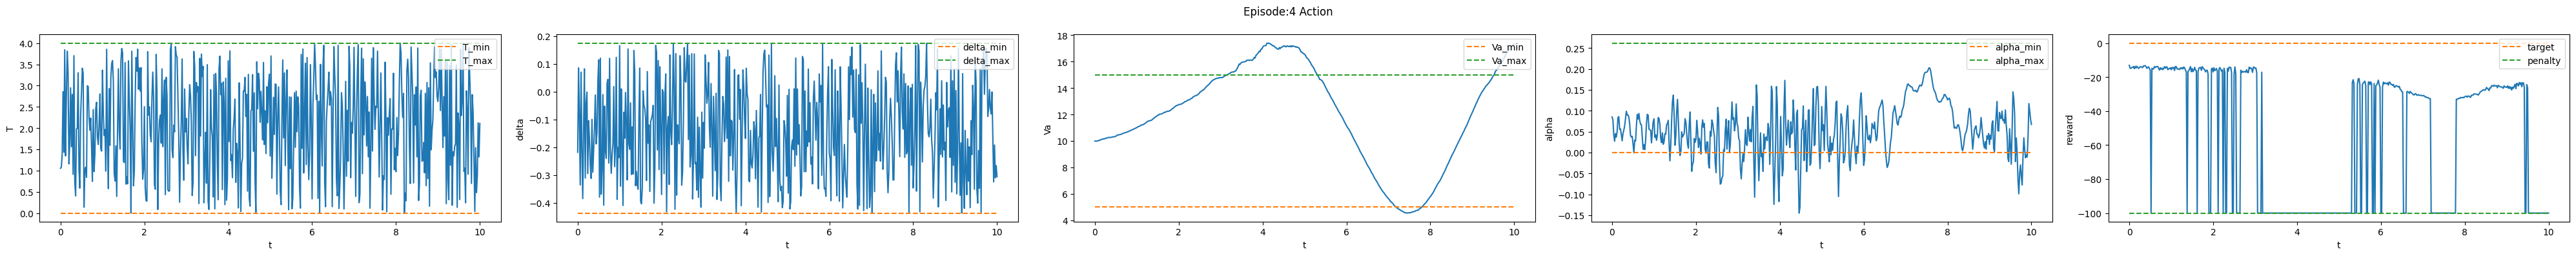

Episode:5 Score:-25555.120523070527


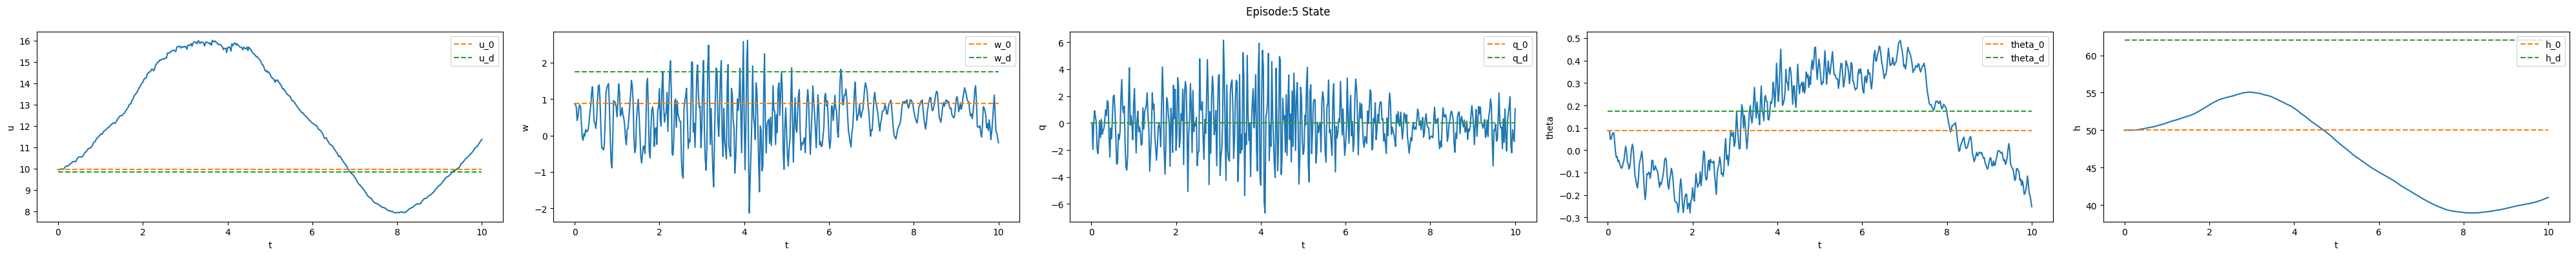

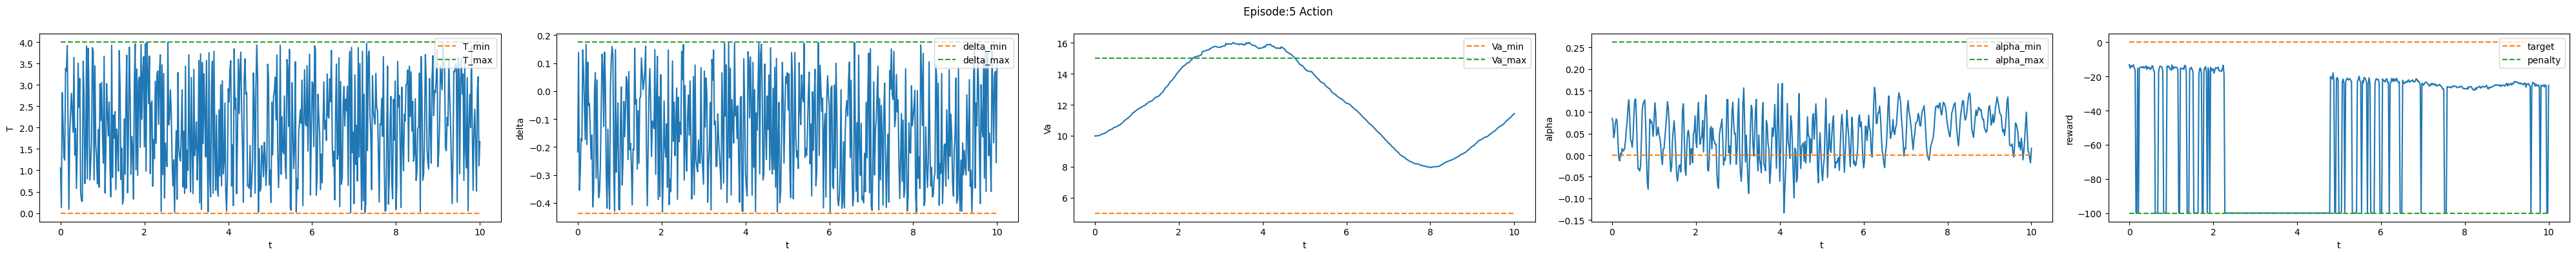

In [89]:
env = UAV_env(action='box', terminate=False)
num_episodes = 5

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        if env.t == 0:
            action = env.U0
        else:
            # action = DQN(state)  # Use DQN in keras-rl2 to get our actual action policy
            action = env.action_space.sample() # Random action to test environment
        U.append(env.transform(action))
        t.append(env.t)
        X.append([state[0], state[1], state[2], state[3], state[4]])
        state, reward, done, _, info = env.step(action)
        score += reward
        R.append(reward)
        I.append([info['Va'], info['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    plot(env, X, U, I, R, t, episode)
    
env.close()

# Agent Setup

In [4]:
from stable_baselines3 import DQN, PPO, DDPG, SAC
from stable_baselines3.common.env_checker import check_env

In [5]:
# Register UAV environment
gym.register('UAV-v0', entry_point=UAV_env)
env = gym.make('UAV-v0')
check_env(env)

# DQN Test

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | -272     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4547     |
|    time_elapsed     | 0        |
|    total_timesteps  | 51       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | -245     |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3888     |
|    time_elapsed     | 0        |
|    total_timesteps  | 87       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | -251  

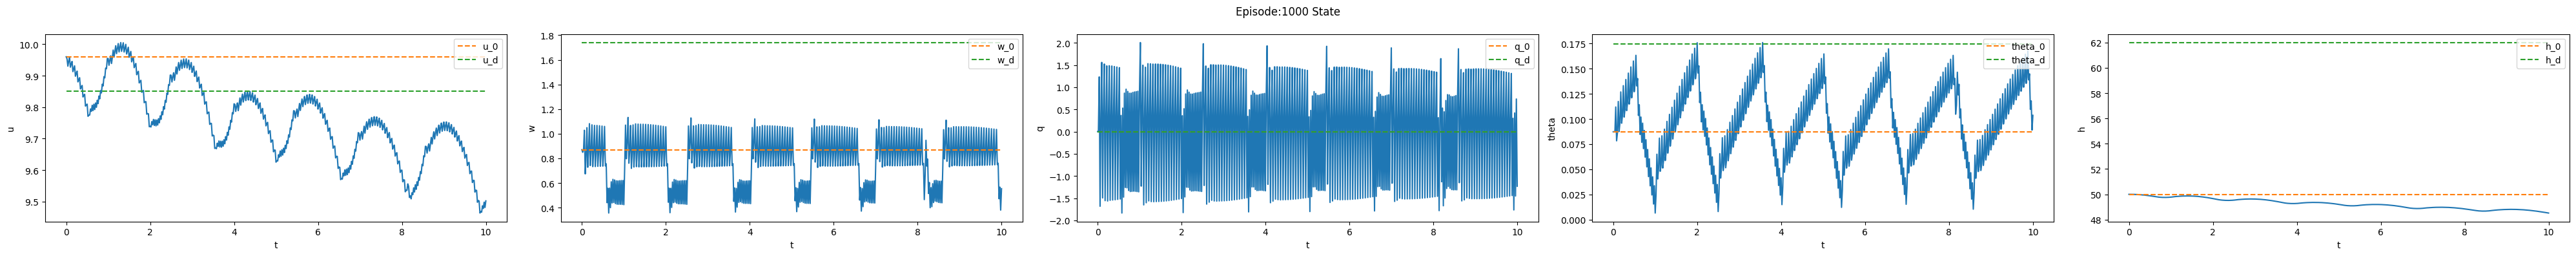

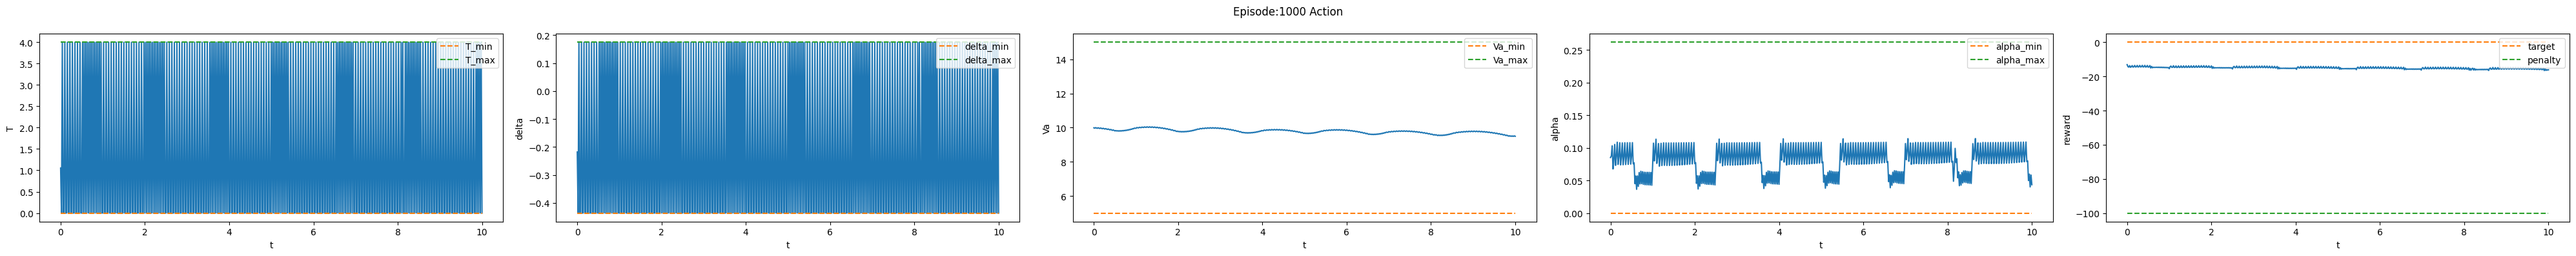

In [93]:
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
vec_env = model.get_env()

num_episodes = 1000

for episode in range(num_episodes):
    state = vec_env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        action = model.predict(state, deterministic=True)[0]
        U.append([env.transform(action[0])[0], env.transform(action[0])[1]])
        t.append(env.t)
        X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
        state, reward, done, info = vec_env.step(action)
        score += reward[0]
        R.append([reward[0]])
        I.append([info[0]['Va'], info[0]['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    if episode == num_episodes-1:
        plot(env, X, U, I, R, t, episode)

env.close()

# PPO Test

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.1     |
|    ep_rew_mean     | -234     |
| time/              |          |
|    fps             | 283      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.94        |
|    ep_rew_mean          | -203        |
| time/                   |             |
|    fps                  | 238         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020182362 |
|    clip_fraction        | 0.439       |
|    clip_range           | 0.2         |
|    entropy_loss  

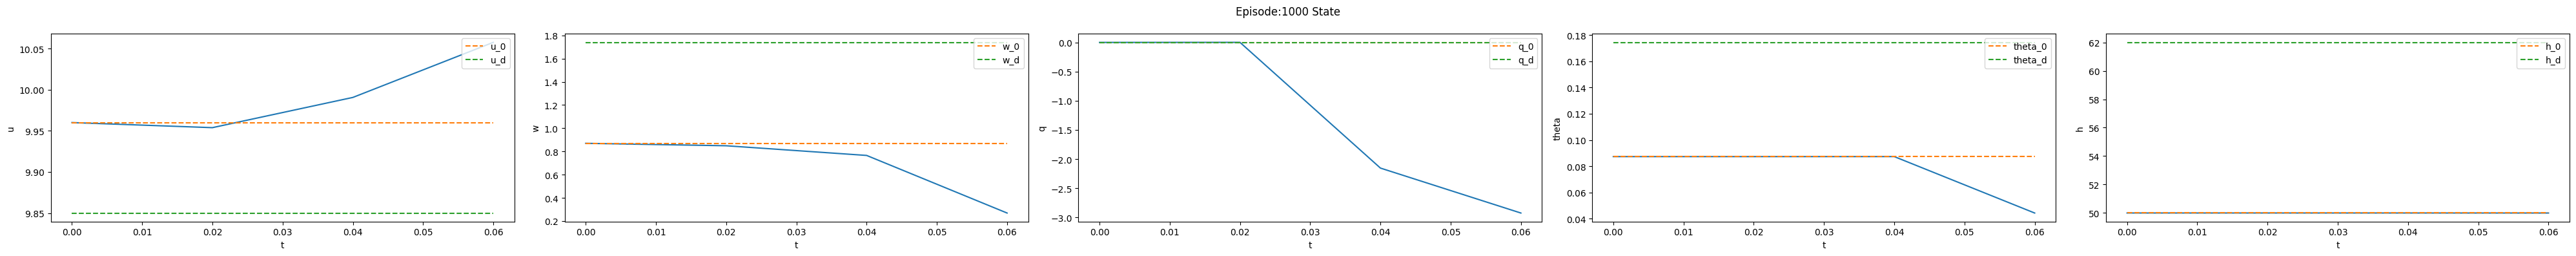

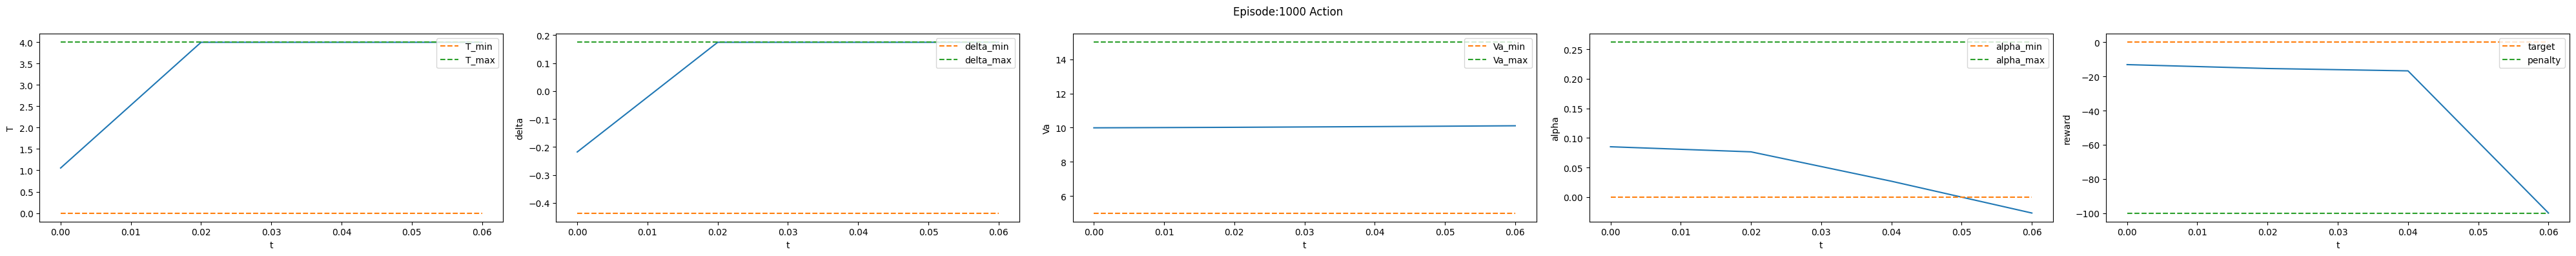

In [6]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
vec_env = model.get_env()

num_episodes = 1000

for episode in range(num_episodes):
    state = vec_env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        action = model.predict(state, deterministic=True)[0]
        U.append([env.transform(action[0])[0], env.transform(action[0])[1]])
        t.append(env.t)
        X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
        state, reward, done, info = vec_env.step(action)
        score += reward[0]
        R.append([reward[0]])
        I.append([info[0]['Va'], info[0]['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    if episode == num_episodes-1:
        plot(env, X, U, I, R, t, episode)

env.close()

# DDPG Test

In [ ]:
model = DDPG("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
vec_env = model.get_env()

num_episodes = 1000

for episode in range(num_episodes):
    state = vec_env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        action = model.predict(state, deterministic=True)[0]
        U.append([env.transform(action[0])[0], env.transform(action[0])[1]])
        t.append(env.t)
        X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
        state, reward, done, info = vec_env.step(action)
        score += reward[0]
        R.append([reward[0]])
        I.append([info[0]['Va'], info[0]['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    if episode == num_episodes-1:
        plot(env, X, U, I, R, t, episode)

env.close()

# SAC Test

In [ ]:
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
vec_env = model.get_env()

num_episodes = 1000

for episode in range(num_episodes):
    state = vec_env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        action = model.predict(state, deterministic=True)[0]
        U.append([env.transform(action[0])[0], env.transform(action[0])[1]])
        t.append(env.t)
        X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
        state, reward, done, info = vec_env.step(action)
        score += reward[0]
        R.append([reward[0]])
        I.append([info[0]['Va'], info[0]['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    if episode == num_episodes-1:
        plot(env, X, U, I, R, t, episode)

env.close()